In [45]:
import bs4
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
import re
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.datasets import load_digits
from math import sqrt

# Pandas로 데이터 정리

In [46]:
df = pd.read_excel('vehicle.xlsx', engine = 'openpyxl')
df_ = df[-31:]
df = df[:-31]
df.head(3)

,Unnamed: 0,CurbWeight,TopSpeed,Displacement,Power,Torque,vehicle,laptime,Price,Zero
0,1.0,1626.0,325.0,4.0,730.0,800.0,AMG GT Black Series,403.62,337800,3.1
1,2.0,1525.0,354.0,6.5,770.0,720.0,Lamborghini Aventador SVJ,404.97,432300,2.8
2,3.0,650.0,290.0,2.8,455.0,380.0,Radical SR8LM,408.00,NaN,3.3


# 선형 회귀

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics, preprocessing


In [53]:
lm = LinearRegression(fit_intercept = True)   # 선형회기함수 정의

In [60]:
Y_data = df["laptime"].values                 # X 데이터, Y 데이터로 나눈 뒤 Train 데이터, Test 데이터로 나눔
X_data = df[["CurbWeight","Displacement","TopSpeed", "Power","Torque","Zero"]].values
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=1234)

In [61]:
lm.fit(X_train,Y_train)                       # Train데이터로 선형회기 훈련

LinearRegression()

In [62]:
Y_pred = lm.predict(X_test)                   # Test데이터로 선형회기 예측 후 RMSE값 측정
difference = lm.predict(X_data)-Y_data
print( "Tree best RMSE : " + str(np.round(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred)),3)))

Tree best RMSE : 12.023


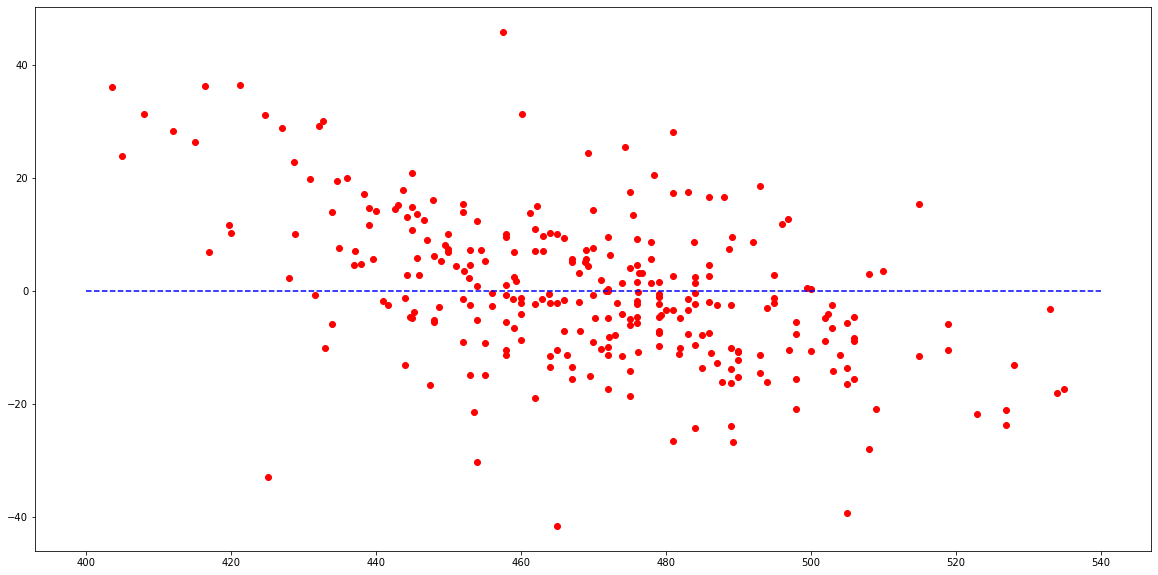

In [63]:
plt.figure(figsize = (20,10))                 # 전체 데이터와 예측값의 차이를 Plot에 시각화
plt.plot([400,540],[0,0],'--', c ='blue')
plt.scatter(Y_data, difference, c = 'red')
plt.show()

In [59]:
para = lm.coef_.round(2)
for p in zip(["CurbWeight","Displacement","TopSpeed", "Power","Torque"],para) :
    print(p)
print(lm.intercept_)

('CurbWeight', 1.5)
('Displacement', -0.1)
('TopSpeed', -0.08)
('Power', 0.03)
('Torque', 12.04)
466.93668010433424


In [64]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.datasets import load_digits

In [65]:
depth_grid = np.arange(1,21)                  # 하이퍼파라미터의 범위 설정
n_estimators=np.arange(50,200)
min_samples_leaf_grid = np.arange(2,31,2)
max_leaf_nodes_grid = np.arange(2,51,2)
parameters = {'max_depth':depth_grid, 'min_samples_leaf':min_samples_leaf_grid, 'max_leaf_nodes':max_leaf_nodes_grid }

In [66]:
gridCV = GridSearchCV(RandomForestRegressor(), parameters, cv=5, n_jobs = -1)   # RandomForestRegressor함수 입력
gridCV.fit(X_train, Y_train)                                                      # 데이터의 최적화된 하이퍼파라미터의 찾기
best_depth = gridCV.best_params_['max_depth']
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']                   
best_max_leaf_nodes = gridCV.best_params_['max_leaf_nodes']

KeyboardInterrupt: 

In [67]:
RFR_best = RandomForestRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,max_leaf_nodes=best_max_leaf_nodes)
RFR_best.fit(X_train, Y_train)                                                  # 최적화된 하이퍼파라미터를 입력하고 훈련
Y_pred = RFR_best.predict(X_test)                                               # 예측모델의 Test데이터를 이용하여 RMSE 출력
print( "Tree best RMSE : " + str(np.round(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred)),3)))
Y_pred_RFR=RFR_best.predict(X_data)

Tree best RMSE : 11.345


In [68]:
best_depth ,best_min_samples_leaf,best_max_leaf_nodes 


(13, 2, 50)

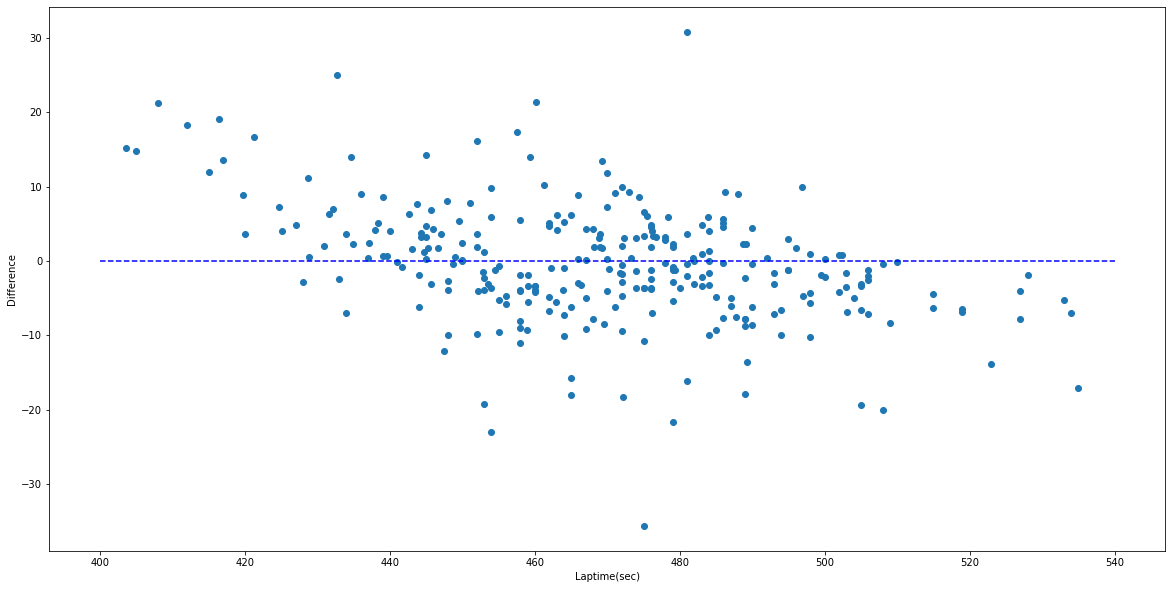

In [69]:
plt.figure(figsize = (20,10))                                                   # 예측모델의 Test데이터를 이용하여 RMSE 출력
plt.plot([400,540],[0,0],'--', c ='blue')
plt.xlabel("Laptime(sec)")
plt.ylabel("Difference")
plt.scatter(Y_data,Y_pred_RFR-Y_data)
plt.show()

In [70]:
RFR_best = RandomForestRegressor(max_depth=19,min_samples_leaf=2,max_leaf_nodes=46)
RFR_best.fit(X_train, Y_train)                                                  # 최적화된 하이퍼파라미터를 입력하고 훈련
Y_pred = RFR_best.predict(X_test)                                               # 예측모델의 Test데이터를 이용하여 RMSE 출력
print( "Tree best RMSE : " + str(np.round(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred)),3)))
Y_pred_RFR=RFR_best.predict(X_data)

Tree best RMSE : 11.601


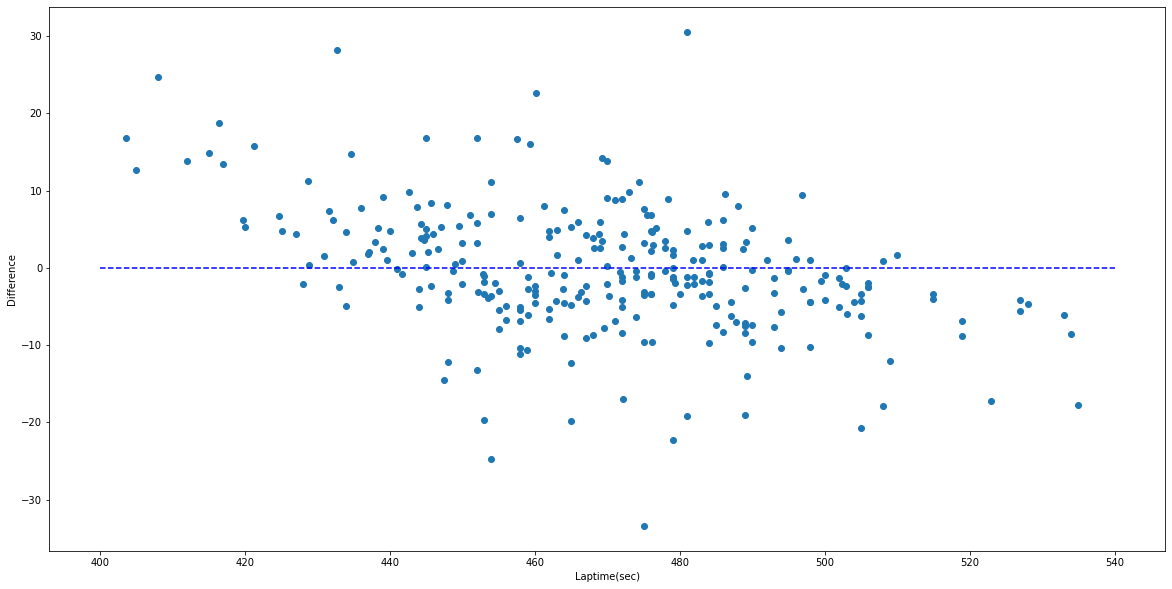

In [71]:
plt.figure(figsize = (20,10))                                                   # 예측모델의 Test데이터를 이용하여 RMSE 출력
plt.plot([400,540],[0,0],'--', c ='blue')
plt.xlabel("Laptime(sec)")
plt.ylabel("Difference")
plt.scatter(Y_data,Y_pred_RFR-Y_data)
plt.show()

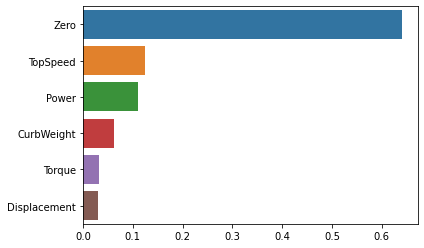

In [72]:
import seaborn as sns
variable_names = ["CurbWeight","Displacement","TopSpeed", "Power","Torque","Zero"]
variable_importance = pd.Series(RFR_best.feature_importances_, index = variable_names)
top_variables_10 = variable_importance.sort_values(ascending=False)[:]
sns.barplot(x=top_variables_10.values, y = top_variables_10.index, ci=None)
plt.show()

In [75]:
print( "Tree best SCORE : " + str(RFR_best.score(X_test,Y_test).round(2)))

Tree best SCORE : 0.69


In [76]:
X_Korea = df_[["CurbWeight","Displacement","TopSpeed", "Power","Torque","Zero"]].values
X_Korea = X_Korea[:-2]
Y_pred = RFR_best.predict(X_Korea)  
for c, l in zip(df_["vehicle"],Y_pred):
    print(c+ "차종의 예상 Laptime은 | "+str(round(l,2)) )

G70 3.3 터보가솔린 차종의 예상 Laptime은 | 485.13
스팅어 3.3 터보가솔린 차종의 예상 Laptime은 | 489.53
K9 3.3 터보가솔린차종의 예상 Laptime은 | 498.9
G90 3.3 터보가솔린 차종의 예상 Laptime은 | 503.35
그랜저 3.3 가솔린 차종의 예상 Laptime은 | 516.4
말리부 2. 0터보 차종의 예상 Laptime은 | 519.24
그랜저 2.4 가솔린 차종의 예상 Laptime은 | 527.53
K7 2.5 가솔린 차종의 예상 Laptime은 | 527.53
팰리세이드 2.2디젤 차종의 예상 Laptime은 | 523.47
I30N 라인 차종의 예상 Laptime은 | 519.91
K3 GT(5도어) 차종의 예상 Laptime은 | 526.75
G80 3.3 가솔린차종의 예상 Laptime은 | 505.35
코나 1.6 터보가솔린 차종의 예상 Laptime은 | 525.13
셀토스 1.6터보가솔린차종의 예상 Laptime은 | 525.19
쏘울 EV 차종의 예상 Laptime은 | 523.7
니로 EV차종의 예상 Laptime은 | 523.7
스포티지 2.0 디젤 차종의 예상 Laptime은 | 518.33
K5 2.0 가솔린 차종의 예상 Laptime은 | 512.15
쏘나타2.0 가솔린 차종의 예상 Laptime은 | 511.9
투싼2.0 디젤 차종의 예상 Laptime은 | 518.51
티볼리 1.6 디젤 차종의 예상 Laptime은 | 521.12
베뉴 1.6 가솔린 차종의 예상 Laptime은 | 523.53
K3 1.6 가솔린 차종의 예상 Laptime은 | 517.6
아반떼 1.6 가솔린 차종의 예상 Laptime은 | 519.3
카니발 2.2디젤 차종의 예상 Laptime은 | 518.34
스파크 1.0 가솔린차종의 예상 Laptime은 | 521.9
모닝 1.0 가솔린 차종의 예상 Laptime은 | 522.33
레이 1.0 가솔린 차종의 예상 Laptime은 | 522.33